In [3]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from PIL import ImageFont, ImageDraw, Image
import imutils
from skimage.filters import threshold_otsu
import skimage.io as io
import math
import csv
from matplotlib.patches import Rectangle
import os

HOST = "192.168.125.5" #my IP address 
SERVER_PORT = 65432
FORMAT = "utf8" 

In [4]:
def neighbours(x,y,image): #for thining algorithm
    "Return 8-neighbours of image point P1(x,y), in a clockwise order"
    img = image
    x_1, y_1, x1, y1 = x-1, y-1, x+1, y+1
    return [ img[x_1][y], img[x_1][y1], img[x][y1], img[x1][y1],     # P2,P3,P4,P5
                img[x1][y], img[x1][y_1], img[x][y_1], img[x_1][y_1] ]    # P6,P7,P8,P9

def transitions(neighbours): #for thining algorithm
    "No. of 0,1 patterns (transitions from 0 to 1) in the ordered sequence"
    n = neighbours + neighbours[0:1]      # P2, P3, ... , P8, P9, P2
    return sum( (n1, n2) == (0, 1) for n1, n2 in zip(n, n[1:]) )  # (P2,P3), (P3,P4), ... , (P8,P9), (P9,P2)

def zhangSuen(image): #main of thining algorithm
    "the Zhang-Suen Thinning Algorithm"
    Image_Thinned = image.copy()  # deepcopy to protect the original image
    changing1 = changing2 = 1        #  the points to be removed (set as 0)
    while changing1 or changing2:   #  iterates until no further changes occur in the image
        # Step 1
        changing1 = []
        rows, columns = Image_Thinned.shape               # x for rows, y for columns
        for x in range(1, rows - 1):                     # No. of  rows
            for y in range(1, columns - 1):            # No. of columns
                P2,P3,P4,P5,P6,P7,P8,P9 = n = neighbours(x, y, Image_Thinned)
                if (Image_Thinned[x][y] == 1     and    # Condition 0: Point P1 in the object regions 
                    2 <= sum(n) <= 6   and    # Condition 1: 2<= N(P1) <= 6
                    transitions(n) == 1 and    # Condition 2: S(P1)=1  
                    P2 * P4 * P6 == 0  and    # Condition 3   
                    P4 * P6 * P8 == 0):         # Condition 4
                    changing1.append((x,y))
                    
        for x, y in changing1: 
            Image_Thinned[x][y] = 0
            
        #Step 2
        changing2 = []
        for x in range(1, rows - 1):
            for y in range(1, columns - 1):
                P2,P3,P4,P5,P6,P7,P8,P9 = n = neighbours(x, y, Image_Thinned)
                if (Image_Thinned[x][y] == 1   and        # Condition 0
                    2 <= sum(n) <= 6  and       # Condition 1
                    transitions(n) == 1 and      # Condition 2
                    P2 * P4 * P8 == 0 and       # Condition 3
                    P2 * P6 * P8 == 0):            # Condition 4
                    changing2.append((x,y))    
        for x, y in changing2: 
            Image_Thinned[x][y] = 0
    return Image_Thinned

def min_thin_ver2(point_pos, mask_test, window_size = 21): # to extract size of pen point
    test_matrix = mask_test[int(point_pos[0]- (window_size-1)/2):int(point_pos[0] + (window_size-1)/2 + 1),
                            int(point_pos[1] - (window_size-1)/2):int(point_pos[1] + (window_size-1)/2 + 1)]
    #test_matrix = test_matrix.astype(int)
    sum_indices = window_size

    mask_1 = np.zeros([window_size,window_size], dtype="uint8")
    mask_1[:,int(window_size/2)] = 1

    mask_2 = np.zeros([window_size,window_size], dtype="uint8")
    mask_2[int(window_size/2),:] = 1
    # diagonal matrix
    mask_3 = np.eye(window_size,window_size)
    mask_3 = mask_3.astype(int)
    # sub diagonal matrix
    mask_4 = np.zeros([window_size,window_size], dtype="uint8")
    i,j = np.indices(mask_4.shape)
    mask_4[i == window_size - 1 - j] = 1
    #window_size = 21
    mask_5 = np.zeros([window_size,window_size], dtype="uint8")
    i,j = np.indices(mask_5.shape)
    mask_5[i-np.floor((window_size-2)/2) == window_size - j*2] = 1
    mask_5[1,14]=1
    mask_5[3,13]=1
    mask_5[5,12]=1
    mask_5[7,11]=1
    mask_5[9,10]=1
    mask_5[10,10]=1
    mask_5[11,10]=1
    mask_5[13,9]=1
    mask_5[15,8]=1
    mask_5[17,7]=1
    mask_5[19,6]=1
    #window_size = 21
    mask_6 = np.zeros([window_size,window_size], dtype="uint8")
    i,j = np.indices(mask_6.shape)
    #mask_6[i-np.floor((window_size-2)/2) == window_size - j*2] = 1
    mask_6[j-np.floor((window_size-2)/2) == window_size - i*2] = 1
    mask_6[5,19]=1
    mask_6[6,17]=1
    mask_6[7,15]=1
    mask_6[8,13]=1
    mask_6[9,11]=1
    mask_6[10,10]=1
    mask_6[11,9]=1
    mask_6[12,7]=1
    mask_6[13,5]=1
    mask_6[14,3]=1
    mask_6[15,1]=1

    mask_7 = np.flip(mask_6,0)
    mask_8 = np.flip(mask_5,0)

    mask_list = [mask_1, mask_2, mask_3, mask_4, mask_5, mask_6, mask_7, mask_8]
    for i in mask_list:
        tmp = sum(sum(test_matrix * i))
        if tmp < sum_indices:
            sum_indices = tmp
    return sum_indices

def calculate_distance(point1, point2): # tính khoảng cách 
    return math.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)

def find_points_with_value(matrix, value):# chuyển ma trận thành mảng các điểm 
    indices = np.argwhere(matrix == value)  
    return indices.tolist()

def choose_point(main, nearest_point, new_point): # chọn điểm gần nhất theo kim đồng hồ 
    if nearest_point[0] >= main[0] and new_point[0] >= main[0]:
        if nearest_point[1] > new_point[1]:
            return False
        else: 
            return True
    elif nearest_point[0] < main[0] and new_point[0] < main[0]:
        if nearest_point[1] < new_point[1]:
            return False
        else: 
            return True
    elif nearest_point[0] < main[0] and new_point[0] > main[0]:
        return True
    else: 
        return False

def add_nearest_point(new_points, points): #tìm điểm tiếp theo 
    min_distance = 0
    while min_distance <= 3 and len(points)>0:

        last_point = new_points[-1]
        nearest_point = points[0]
        min_distance = calculate_distance(last_point, nearest_point)
        
        for point in points:
            distance = calculate_distance(last_point, point)

            if distance < min_distance or (distance == min_distance and choose_point(last_point, nearest_point, point)):
                nearest_point = point
                min_distance = distance
        if nearest_point != new_points[-1] and min_distance <=3 :
            new_points.append(nearest_point)

        points.remove(nearest_point)

def find_start_point(points,final, constant_distance, heso): # tìm điểm đầu tiên để bắt đầu
    if not points:
        return None
    min_point = points[0]
    min_distance = calculate_distance([0,0], points[0])
    m =0
    n = constant_distance*heso[0] +50
    for point in points:
        if point[1] < n:
            m =1
        
    if m == 0:
        heso[0]+=1
        n = constant_distance*heso[0] +50
        for point in points:
            distance = calculate_distance([0,0], point)
            if distance < min_distance and sum(sum(final[point[0]-1:point[0]+2,point[1]-1:point[1]+2])) <= 2 :
                min_point = point
                min_distance = distance
    else:
        min_distance = calculate_distance([0,0], [1000,0])
        for point in points:
            distance = calculate_distance([0,0], point)
            if point[1] < n:
                if distance < min_distance and sum(sum(final[point[0]-1:point[0]+2,point[1]-1:point[1]+2])) <= 5:
                    min_point = point
                    min_distance = distance
    #print("Khoảng cách: " ,min_distance, ", Điểm bắt đầu: ", min_point, ", hệ số n:", n, ", Điểm đầu tiên: ", points[0])
    return min_point

def final_points(final):
    constant_distance = 65 
    heso = [1] 

    all_points= find_points_with_value(final, value=1)
    new_points =[]
    raw_points =[]
    while all_points:
        start_point = find_start_point(all_points,final,constant_distance,heso)
        if start_point != None: 
            raw_points.append(start_point)
        add_nearest_point(raw_points, all_points)
        new_points = new_points + raw_points
        new_points.append([21,21])
        raw_points =[]
        # print(new_points)
    return new_points

def final_points_rdp(final):
    constant_distance = 65 
    heso = [1] 

    all_points= find_points_with_value(final, value=1)
    new_points =[]
    raw_points =[]
    while all_points:
        start_point = find_start_point(all_points,final,constant_distance,heso)
        if start_point != None: 
            raw_points.append(start_point)
        add_nearest_point(raw_points, all_points)
        new_points = new_points + rdp(raw_points, 1.5)
        new_points.append([21,21])
        raw_points =[]
        # print(new_points)
    return new_points

def create_coordination_visual(fontpath, text_input, row = 100, column = -40, horizontal = 600, height = 200): # create path for R-arm procedure
    mask = np.zeros([height,horizontal,3], dtype="uint8")
    
    font = ImageFont.truetype(fontpath,140)
    img_pil = Image.fromarray(mask)
    draw = ImageDraw.Draw(img_pil)
    draw.text((row, column),  text_input, font = font, fill = (0, 255, 0))

    img = np.array(img_pil)
    img = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    
    mask_ = np.full((height,horizontal), False)
    mask_[img != 0] = True

    final = zhangSuen(mask_)
    arr = final_points(final)
    mask_test = mask_.copy()
    n= horizontal/height
    plt.figure(figsize=(10,10*n), facecolor='black')
    plt.imshow(mask_test, cmap = "gray")
    plt.axis('off')
    plt.show()
    #print(min_thin(arr[0]))
    arr_thining = []
    for j, i in enumerate(arr):
        if j%1==0:
            arr_thining.append([i[0],i[1],min_thin_ver2(i,mask_test)])
    return arr_thining

def create_coordination_rdp(fontpath, text_input, row = 100, column = -40, horizontal = 600, height = 200): # create path for R-arm procedure
    mask = np.zeros([height,horizontal,3], dtype="uint8")
    
    font = ImageFont.truetype(fontpath,140)
    img_pil = Image.fromarray(mask)
    draw = ImageDraw.Draw(img_pil)
    draw.text((row, column),  text_input, font = font, fill = (0, 255, 0))

    img = np.array(img_pil)
    img = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    
    mask_ = np.full((height,horizontal), False)
    mask_[img != 0] = True

    final = zhangSuen(mask_)
    arr = final_points_rdp(final)
    mask_test = mask_.copy()
    #print(min_thin(arr[0]))
    arr_thining = []
    for j, i in enumerate(arr):
        if j%1==0:
            arr_thining.append([i[0],i[1],min_thin_ver2(i,mask_test)])
    return arr_thining

def rdp(points, epsilon):
    def line_length(point1, point2):
        return math.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)

    def perpendicular_distance(point, line_start, line_end):
        if line_start == line_end:
            return line_length(point, line_start)
        n = abs(
            (line_end[0] - line_start[0]) * (line_start[1] - point[1]) -
            (line_start[0] - point[0]) * (line_end[1] - line_start[1])
        )
        d = line_length(line_start, line_end)
        return n / d

    def rdp_recursive(start_idx, end_idx):
        if end_idx - start_idx <= 1:
            return [points[start_idx], points[end_idx]]

        max_distance = 0
        farthest_point_index = 0
        line_start = points[start_idx]
        line_end = points[end_idx]

        for i in range(start_idx + 1, end_idx):
            distance = perpendicular_distance(points[i], line_start, line_end)
            if distance > max_distance:
                max_distance = distance
                farthest_point_index = i

        if max_distance > epsilon:
            left_segment = rdp_recursive(start_idx, farthest_point_index)
            right_segment = rdp_recursive(farthest_point_index, end_idx)
            return left_segment[:-1] + right_segment  # Exclude the duplicated point
        else:
            return [line_start, line_end]

    if len(points) < 2:
        return points
    return rdp_recursive(0, len(points) - 1)

def hienthi2(trajectory):
    print(trajectory)
    arr = np.array(trajectory)

    # Tính toán phạm vi của dữ liệu
    x_min, x_max = np.min(arr[:, 0]), np.max(arr[:, 0])
    y_min, y_max = np.min(arr[:, 1]), np.max(arr[:, 1])

    # Tính toán kích thước hình vẽ dựa trên tỷ lệ giữa phạm vi x và y và một hệ số (vd: 0.1)
    x_range = x_max - x_min
    y_range = y_max - y_min
    aspect_ratio = y_range / x_range
    figsize = (7 * aspect_ratio, 7)

    plt.figure(figsize=figsize,facecolor='black')
    cl = 0
    cl_ = 0
    colors = np.array(["red", "green", "blue", "yellow", "orange", "purple", "gray", "magenta", "pink"])
    col_step_ = np.ceil(len(arr) / len(colors))
    col_step = col_step_
    for i in arr:
        if i[0] != 21:
            if cl > col_step:
                col_step += col_step_
                cl_ += 1
            plt.scatter([i[1]], [i[0]], color=colors[cl_], linewidths=0.1)
            cl += 1
    plt.gca().invert_yaxis()
    plt.axis('off')
    plt.show()

def add_split(arr_thining): # add point[*,*,0] to split uncontinue line
   arr_thining_ = []
   #append first point with z = 0
   arr_thining_.append([arr_thining[0][0],arr_thining[0][1],0])




   for num in range(0,len(arr_thining)-1):
        if arr_thining[num][0] == 21 and  arr_thining[num][1] == 21:
            arr_thining_.append([arr_thining[num-1][0],arr_thining[num-1][1],0])
            arr_thining_.append([arr_thining[num+1][0],arr_thining[num+1][1],0])
        else :
            arr_thining_.append([arr_thining[num][0],arr_thining[num][1],arr_thining[num][2]])
   #append last point with z = 0
   arr_thining_.append([arr_thining[-2][0],arr_thining[-2][1],0])
   return arr_thining_

def calib(arr_thining_, h_origin = 135*1.2, w_origin= 80*1.2 , h_pixel = 900, w_pixel = 550):
   arr_thining_1 = arr_thining_.copy()
   arr_thining_2 = np.array(arr_thining_1)

   arr_thining_2[:,0] = (np.floor((arr_thining_2[:,0]/h_pixel)*h_origin)).astype(int)
   arr_thining_2[:,1] = (np.floor((arr_thining_2[:,1]/w_pixel)*w_origin)).astype(int)

   arr_Z = []

   for i in range(len(arr_thining_2[:,2])):
       if arr_thining_2[:,2][i] == 0:
           arr_Z.append(1)
       else:
           if int((arr_thining_2[:,2][i]-1)*(-11/25)) > -1:
               arr_Z.append(int(-1))
           elif int((arr_thining_2[:,2][i]-1)*(-11/25)) < -10:
               arr_Z.append(int(-10))
           else:
               arr_Z.append(int((arr_thining_2[:,2][i]-1)*(-11/25)))


         
   arr_thining_3 = np.stack((arr_thining_2[:,0],arr_thining_2[:,1],arr_Z), axis = 1)




   return arr_thining_3

def cvt_2_string(arr_int):
   arr_str = []
   for i in range( 0, len(arr_int)):
       arr_str.append(str(arr_int[i][0])+";"+str(arr_int[i][1])+";"+str(arr_int[i][2]))
   return arr_str



In [13]:
#lưu file
file_path = "/Users/anhduc/Documents/Project_Program/Final_Project/Thuc_nghiem"
main_split = add_split(main_trajectory)
main_calib = calib(main_split, h_origin = 45*2, w_origin= 80*2 , h_pixel= 300,  w_pixel = 550)
main_str = cvt_2_string(main_calib)

with open(f"{file_path}/{text}", "w") as tep:
    for i in main_str:
        tep.write(i+"\n")

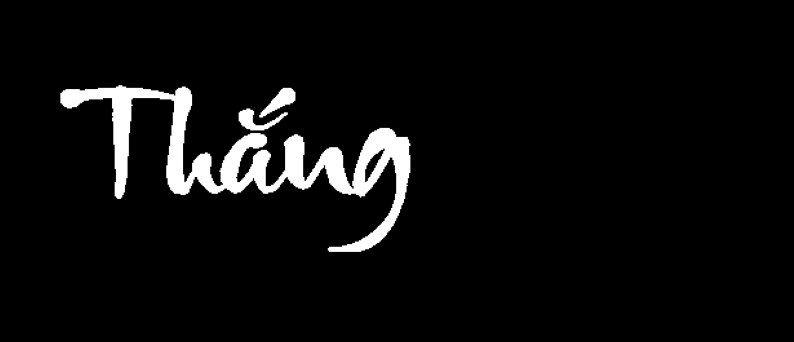

[[67, 48, 11], [67, 49, 11], [67, 50, 11], [67, 51, 10], [67, 52, 10], [66, 53, 9], [66, 54, 9], [66, 55, 9], [66, 56, 8], [66, 57, 8], [66, 58, 7], [66, 59, 7], [66, 60, 7], [66, 61, 7], [65, 62, 8], [65, 63, 8], [65, 64, 8], [65, 65, 8], [65, 66, 8], [65, 67, 8], [65, 68, 7], [65, 69, 8], [65, 70, 8], [65, 71, 8], [64, 72, 8], [64, 73, 8], [64, 74, 8], [64, 75, 8], [64, 76, 8], [64, 77, 8], [64, 78, 8], [64, 79, 8], [64, 80, 9], [64, 81, 10], [64, 82, 9], [65, 83, 10], [66, 84, 11], [67, 85, 13], [67, 86, 14], [67, 87, 14], [66, 87, 12], [66, 88, 12], [65, 88, 11], [65, 89, 10], [65, 90, 11], [64, 91, 10], [64, 92, 9], [64, 93, 8], [64, 94, 8], [64, 95, 8], [64, 96, 8], [64, 97, 8], [64, 98, 8], [65, 99, 8], [65, 100, 8], [65, 101, 7], [65, 102, 7], [65, 103, 7], [65, 104, 7], [65, 105, 7], [65, 106, 6], [65, 107, 6], [65, 108, 6], [65, 109, 6], [65, 110, 6], [65, 111, 6], [66, 112, 5], [66, 113, 5], [66, 114, 5], [66, 115, 5], [66, 116, 5], [66, 117, 4], [67, 118, 5], [67, 119, 5], 

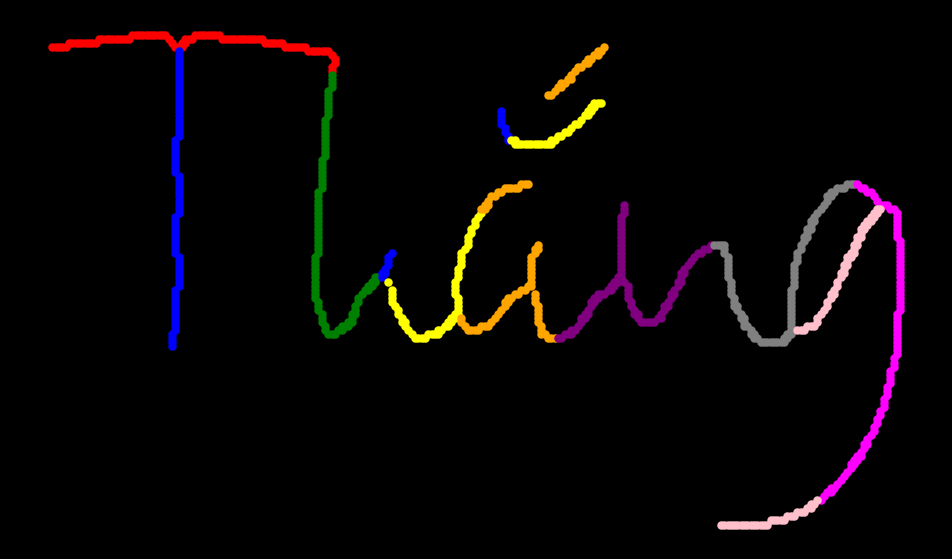

[[67, 48, 11], [64, 72, 8], [64, 82, 9], [67, 87, 14], [64, 91, 10], [64, 98, 8], [68, 131, 11], [71, 133, 12], [119, 127, 12], [135, 129, 10], [138, 131, 12], [136, 137, 12], [129, 140, 6], [123, 148, 14], [118, 150, 9], [21, 21, 0], [68, 86, 15], [126, 86, 9], [141, 84, 6], [21, 21, 0], [83, 183, 9], [90, 185, 6], [91, 198, 4], [81, 213, 5], [21, 21, 0], [125, 149, 14], [130, 150, 8], [139, 157, 7], [138, 164, 4], [133, 170, 14], [125, 169, 12], [107, 177, 7], [102, 184, 9], [101, 191, 10], [21, 21, 0], [134, 171, 8], [137, 173, 9], [136, 179, 9], [129, 185, 7], [126, 192, 12], [116, 194, 10], [21, 21, 0], [79, 197, 5], [67, 214, 9], [21, 21, 0], [128, 193, 9], [138, 195, 4], [138, 204, 5], [128, 212, 5], [124, 219, 14], [106, 220, 12], [21, 21, 0], [125, 220, 12], [133, 223, 7], [135, 229, 7], [118, 242, 12], [116, 250, 13], [128, 252, 11], [136, 256, 8], [140, 261, 7], [140, 268, 11], [138, 270, 10], [118, 272, 8], [103, 282, 14], [101, 290, 17], [108, 302, 14], [143, 302, 7], [156

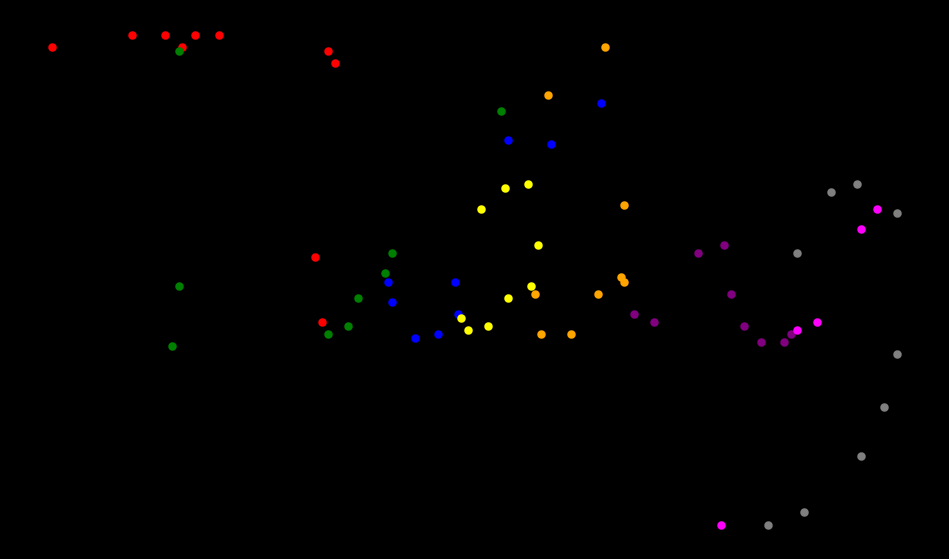

In [12]:
fontpath = '/Users/anhduc/Documents/Project_Program/Final_Project/font/UTM ONG DO GIA.TTF'
text = 'Thắng'
x = 50
y = 0
d = 250 
n = 600
hienthi2(create_coordination_visual(fontpath, text, x, y ,n ,d))
main_trajectory = create_coordination_rdp(fontpath, text, x, y ,n ,d)
hienthi2(main_trajectory)